In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
import pandas as pd

train = pd.read_csv('/Users/vadimartemov/Desktop/Data 2/train.csv')
test = pd.read_csv('/Users/vadimartemov/Desktop/Data 2/test.csv')

In [9]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vadimartemov/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


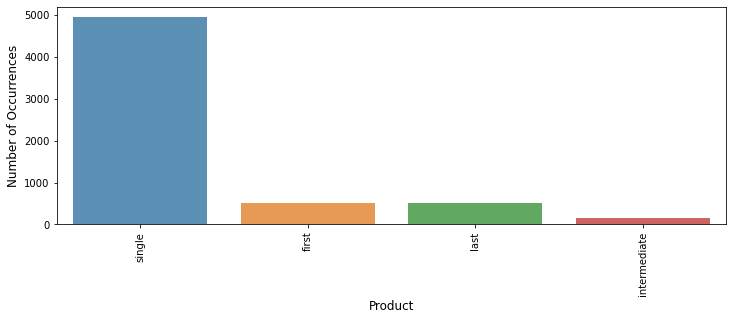

In [10]:
train['MLclass'] = train['MLclass'].astype('str')
test['MLclass'] = test['MLclass'].astype('str')
train['Text'] = train['Text'].astype('str')
test['Text'] = test['Text'].astype('str')
cnt_pro = train['MLclass'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [15]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Text']), tags=[r.MLclass]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Text']), tags=[r.MLclass]), axis=1)

import multiprocessing

from gensim.models import Doc2Vec

from tqdm import tqdm
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha


100%|██████████| 6128/6128 [00:00<00:00, 3263005.57it/s]
UsageError: Line magic function `%%time` not found.


In [18]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [19]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.8531331592689295
Testing F1 score: 0.8221362678345169


In [24]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [32]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [29]:
y_pred=rf_random.predict(X_test)

In [31]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.8531331592689295
Testing F1 score: 0.8221637629445081


In [33]:
rf1 = RandomForestClassifier(n_estimators = 1000,
 min_samples_split = 5,
 min_samples_leaf = 2,
 max_features = 'sqrt',
 max_depth = 100,
 bootstrap = False)

In [34]:
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=100, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1000)

In [35]:
y_pred=rf_random.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.8531331592689295
Testing F1 score: 0.8221637629445081


In [36]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 10.0 MB/s eta 0:00:0000:0100:01
